Named Entity Recognition
- 개체 인식하기
- 어떤 이름을 의마하는 단어를 보고 유형 파악하기
- 예시
    - 유정이는 2018년에 삼성에 입사했다.
    - 유정 (사람) / 2018년 (시간) / 삼성(조직)

NLTK를 이용하여 개체명 인식하기
- NER chunker

In [1]:
from nltk import word_tokenize, pos_tag, ne_chunk

sentence = "James is working at Disney in London"
tokenized_sentence = pos_tag(word_tokenize(sentence))
print(tokenized_sentence)

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [2]:
# 개체명 인식
ner_sentence = ne_chunk(tokenized_sentence)
print(ner_sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


BIO 표현 이해하기
- B : Begin
- I : Inside
- O : Outside

In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [15]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")

f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence)>0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    
    splits = line.split(' ')
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 제거
    word = splits[0].lower()
    sentence.append([word, splits[-1]]) # 단어, 개체명 태깅 

In [16]:
print("전체 샘플 개수: ", len(tagged_sentences)) # 전체 샘플의 개수 출력

전체 샘플 개수:  14041


In [17]:
tagged_sentences[0]

[['eu', 'B-ORG'],
 ['rejects', 'O'],
 ['german', 'B-MISC'],
 ['call', 'O'],
 ['to', 'O'],
 ['boycott', 'O'],
 ['british', 'B-MISC'],
 ['lamb', 'O'],
 ['.', 'O']]

In [19]:
# 단어와 태그끼리 저장해주기
sentences, ner_tags = [] , []

for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


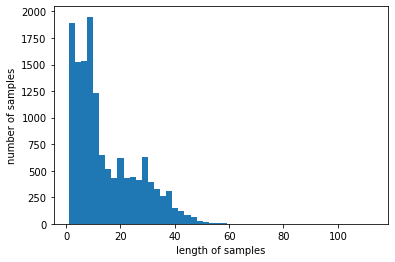

In [20]:
print('샘플의 최대 길이 : %d' % max(len(sentence) for sentence in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
# 정수 인코딩
vocab_size = 4000
src_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

print('첫번째 샘플의 문장 :',X_train[0])
print('첫번째 샘플의 레이블 :',y_train[0])

첫번째 샘플의 문장 : [989, 1, 205, 629, 7, 3939, 216, 1, 3]
첫번째 샘플의 레이블 : [4, 1, 7, 1, 1, 1, 7, 1, 1]


In [22]:
# 문장 데이터 'OOV' 확인하기
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 각 정수로 변환된 단어에 대해서
    decoded.append(index_to_word[index]) # 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))


기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [23]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

tag_size = len(tar_tokenizer.word_index) + 1

y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))


훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax'))) # 다대다 구조를 위한 TimeDistributed

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=8, validation_data=(X_test, y_test))

2022-08-02 16:21:08.645186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-02 16:21:08.645292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-08-02 16:21:09.798052: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/8


2022-08-02 16:21:11.540229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 16:21:12.519964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 16:21:12.695247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 16:21:15.647324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 16:21:15.809779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 0.3344 - accuracy: 0.8203

2022-08-02 16:21:37.787072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 16:21:38.226168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 16:21:38.290979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 31s 272ms/step - loss: 0.3344 - accuracy: 0.8203 - val_loss: 0.2453 - val_accuracy: 0.8330
Epoch 2/8
88/88 [==============================] - 22s 247ms/step - loss: 0.2394 - accuracy: 0.8334 - val_loss: 0.2261 - val_accuracy: 0.8330
Epoch 3/8
88/88 [==============================] - 22s 245ms/step - loss: 0.2214 - accuracy: 0.8320 - val_loss: 0.2081 - val_accuracy: 0.8334
Epoch 4/8
88/88 [==============================] - 21s 243ms/step - loss: 0.2011 - accuracy: 0.8372 - val_loss: 0.1851 - val_accuracy: 0.8454
Epoch 5/8
88/88 [==============================] - 21s 244ms/step - loss: 0.1761 - accuracy: 0.8514 - val_loss: 0.1621 - val_accuracy: 0.8570
Epoch 6/8
88/88 [==============================] - 21s 244ms/step - loss: 0.1559 - accuracy: 0.8642 - val_loss: 0.1432 - val_accuracy: 0.8710
Epoch 7/8
88/88 [==============================] - 22s 246ms/step - loss: 0.1384 - accuracy: 0.8751 - val_loss: 0.1295 - val_accuracy: 0.8798
Epoch 8/8
88/88 

In [25]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))


88/88 [==============================] - 4s 43ms/step - loss: 0.0749 - accuracy: 0.8897

 테스트 정확도: 0.8897


In [26]:
i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict(np.array([X_test[i]]))

# 확률 벡터를 정수 레이블로 변경.
y_predicted = np.argmax(y_predicted, axis=-1)

# 원-핫 벡터를 정수 인코딩으로 변경.
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag].upper(), index_to_ner[pred].upper()))

2022-08-02 16:24:19.601638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 16:24:20.141162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 16:24:20.217130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   B-LOC
,                : O       O
whose            : O       O
republican       : B-MISC  I-ORG
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   O
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  O
convention       : I-MISC  O
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O       O
president        :